In [1]:
#| default_exp training

In [5]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F

In [6]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

## Initial setup

### Data

In [7]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [10]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]

    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [11]:
model = Model(m, nh, 10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

### Cross entropy loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum\limits_{0 \leq j \lt n} e^{x_{j}}}$$

In practice, we will need the log of the softmax when we calculate the loss.

In [12]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [13]:
log_softmax(pred)

tensor([[-2.13, -2.29, -2.27,  ..., -2.18, -2.38, -2.36],
        [-2.11, -2.37, -2.36,  ..., -2.10, -2.38, -2.29],
        [-2.31, -2.37, -2.24,  ..., -2.08, -2.35, -2.32],
        ...,
        [-2.14, -2.52, -2.24,  ..., -2.21, -2.40, -2.36],
        [-2.23, -2.33, -2.35,  ..., -2.19, -2.26, -2.33],
        [-2.19, -2.39, -2.26,  ..., -2.21, -2.38, -2.33]], grad_fn=<LogBackward0>)

Note that the formula

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$

gives a simplification when we compute the log softmax:

In [14]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [16]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us.

In [17]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [18]:
test_close(logsumexp(pred), pred.logsumexp(-1))
sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.13, -2.29, -2.27,  ..., -2.18, -2.38, -2.36],
        [-2.11, -2.37, -2.36,  ..., -2.10, -2.38, -2.29],
        [-2.31, -2.37, -2.24,  ..., -2.08, -2.35, -2.32],
        ...,
        [-2.14, -2.52, -2.24,  ..., -2.21, -2.40, -2.36],
        [-2.23, -2.33, -2.35,  ..., -2.19, -2.26, -2.33],
        [-2.19, -2.39, -2.26,  ..., -2.21, -2.38, -2.33]], grad_fn=<SubBackward0>)

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded (actually, they're just the integer indices), this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

This can be done using numpy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing). Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

In [19]:
y_train[:3]

tensor([5, 0, 4])

In [20]:
sm_pred[0,5],sm_pred[1,0],sm_pred[2,4]

(tensor(-2.25, grad_fn=<SelectBackward0>),
 tensor(-2.11, grad_fn=<SelectBackward0>),
 tensor(-2.45, grad_fn=<SelectBackward0>))

In [21]:
sm_pred[[0,1,2], y_train[:3]]

tensor([-2.25, -2.11, -2.45], grad_fn=<IndexBackward0>)

In [22]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [23]:
loss = nll(sm_pred, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

Then use PyTorch's implementation.

In [24]:
test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), loss, 1e-3)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [25]:
test_close(F.cross_entropy(pred, y_train), loss, 1e-3)

## Basic training loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [26]:
loss_func = F.cross_entropy

In [27]:
bs=50                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions
preds[0], preds.shape

(tensor([ 0.20,  0.04,  0.06, -0.06, -0.05,  0.08, -0.10,  0.15, -0.05, -0.03], grad_fn=<SelectBackward0>),
 torch.Size([50, 10]))

In [28]:
yb = y_train[0:bs]
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
        3, 9, 8, 5, 9, 3])

In [29]:
loss_func(preds, yb)

tensor(2.31, grad_fn=<NllLossBackward0>)

In [30]:
preds.argmax(dim=1)

tensor([0, 7, 7, 7, 5, 7, 0, 7, 5, 7, 0, 7, 7, 5, 7, 7, 0, 0, 7, 7, 7, 7, 7, 7, 0, 7, 5, 7, 5, 7, 7, 7, 5, 7, 7, 7, 0, 7, 0, 5, 5, 0, 5, 5,
        0, 5, 0, 5, 7, 7])

In [31]:
#|export
def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

In [32]:
accuracy(preds, yb)

tensor(0.06)

In [33]:
lr = 0.5   # learning rate
epochs = 3 # how many epochs to train for

In [34]:
#|export
def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [35]:
xb,yb = x_train[:bs],y_train[:bs]
preds = model(xb)
report(loss_func(preds, yb), preds, yb)

2.31, 0.06


In [36]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()
    report(loss, preds, yb)

0.13, 0.96
0.08, 0.98
0.09, 0.98


## Using parameters and optim

### Parameters

In [37]:
m1 = nn.Module()
m1.foo = nn.Linear(3,4)
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [38]:
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [39]:
m1.named_children()

<generator object Module.named_children at 0x7b9373b0a420>

In [40]:
list(m1.parameters())

[Parameter containing:
 tensor([[ 0.15,  0.15, -0.24],
         [ 0.16, -0.04,  0.30],
         [-0.05,  0.50, -0.26],
         [-0.40, -0.52,  0.38]], requires_grad=True),
 Parameter containing:
 tensor([ 0.35,  0.43, -0.28,  0.16], requires_grad=True)]

In [42]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        self.relu = nn.ReLU()

    def forward(self, x): return self.l2(self.relu(self.l1(x)))

In [43]:
model = MLP(m, nh, 10)
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [44]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [45]:
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [46]:
for p in model.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [47]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(n,i+bs))
            xb,yb = x_train[s],y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()
        report(loss, preds, yb)

In [48]:
fit()

0.09, 0.96
0.06, 0.98
0.06, 1.00


Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

In [49]:
class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)

    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)

    def __repr__(self): return f'{self._modules}'

    def parameters(self):
        for l in self._modules.values(): yield from l.parameters()

In [50]:
mdl = MyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [51]:
for p in mdl.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


### Registering modules

In [53]:
from functools import reduce

We can use the original `layers` approach, but we have to register the modules.

In [54]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [55]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)

    def forward(self, x): return reduce(lambda val,layer: layer(val), self.layers, x)

In [56]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [57]:
model(xb).shape

torch.Size([50, 10])

### nn.ModuleList

`nn.ModuleList` does this for us.

In [58]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

In [59]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [60]:
fit()

0.15, 0.96
0.11, 0.96
0.09, 0.94


### nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

In [61]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [62]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.18, 0.94
0.13, 0.96
0.11, 0.94


(tensor(0.03, grad_fn=<NllLossBackward0>), tensor(1.))

In [63]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

### optim

In [65]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr

    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [66]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [67]:
opt = Optimizer(model.parameters())

In [68]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.12, 0.98
0.09, 0.98
0.07, 0.98


PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later)

In [69]:
from torch import optim

In [70]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [71]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.31, grad_fn=<NllLossBackward0>)

In [72]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.17, 0.96
0.11, 0.94
0.09, 0.96


## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[s]
    yb = y_train[s]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[s]
```

In [74]:
#|export
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [75]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [79]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [80]:
model,opt = get_model()

In [78]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        xb,yb = train_ds[i:min(n,i+bs)]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.11, 0.98
0.09, 0.98
0.06, 1.00


### DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range(0, n, bs):
    xb,yb = train_ds[i:min(n,i+bs)]
    ...
```

Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    ...
```

In [81]:
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [82]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [83]:
xb,yb = next(iter(valid_dl))
xb.shape

torch.Size([50, 784])

In [84]:
yb

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3,
        8, 3, 7, 7, 8, 4])

tensor(3)

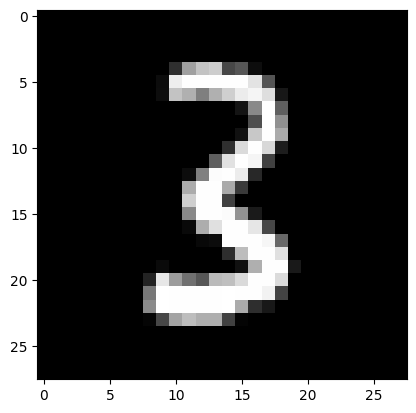

In [85]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [86]:
model,opt = get_model()

In [87]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

In [88]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.11, 0.98
0.07, 1.00
0.08, 0.98


(tensor(0.04, grad_fn=<NllLossBackward0>), tensor(1.))

### Random sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [89]:
import random

In [91]:
class Sampler():
    def __init__(self, ds, shuffle=False): self.n,self.shuffle = len(ds),shuffle
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle: random.shuffle(res)
        return iter(res)

In [92]:

from itertools import islice

In [93]:
ss = Sampler(train_ds)

In [105]:
it = iter(ss)
for o in range(5): print(next(it))

17982
23245
34240
6020
41945


In [108]:
list(islice(ss, 5))

[31873, 27940, 40553, 3332, 12479]

In [111]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[32812, 47556, 36973, 33110, 10626]

In [97]:
import fastcore.all as fc

In [98]:
class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False): fc.store_attr()
    def __iter__(self): yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [99]:
batchs = BatchSampler(ss, 4)
list(islice(batchs, 5))

[[24947, 4552, 27929, 19006],
 [17155, 41735, 15185, 18674],
 [39972, 31218, 11681, 6567],
 [15061, 20958, 23984, 49635],
 [39363, 28941, 15660, 42280]]

In [112]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

In [113]:
class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate): fc.store_attr()
    def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [114]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True ), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [115]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

tensor(3)

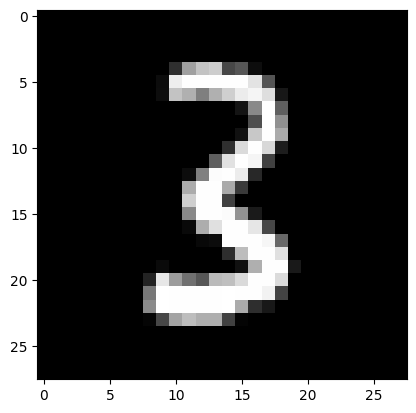

In [116]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [ ]:
xb.shape,yb.shape

(torch.Size([50, 784]), torch.Size([50]))

In [ ]:
model,opt = get_model()

In [ ]:
fit()

0.27, 0.04
0.15, 0.02
0.01, 0.12


### Multiprocessing DataLoader

In [ ]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

In [ ]:
train_ds[[3,6,8,1]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [ ]:
train_ds.__getitem__([3,6,8,1])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [ ]:
for o in map(train_ds.__getitem__, ([3,6],[8,1])): print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0]))


In [ ]:
class DataLoader():
    def __init__(self, ds, batchs, n_workers=1, collate_fn=collate): fc.store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex: yield from ex.map(self.ds.__getitem__, iter(self.batchs))

In [ ]:
train_dl = DataLoader(train_ds, batchs=train_samp, n_workers=2)
it = iter(train_dl)

In [ ]:
xb,yb = next(it)
xb.shape,yb.shape

### PyTorch DataLoader

In [ ]:
#|export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [ ]:
train_samp = BatchSampler(RandomSampler(train_ds),     bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

In [ ]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)

In [ ]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.10, 0.06
0.10, 0.04
0.27, 0.06


(tensor(0.05, grad_fn=<NllLossBackward0>), tensor(0.98))

PyTorch can auto-generate the BatchSampler for us:

In [ ]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

PyTorch can also generate the Sequential/RandomSamplers too:

In [ ]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2)

In [ ]:
model,opt = get_model()
fit()

loss_func(model(xb), yb), accuracy(model(xb), yb)

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


0.21, 0.14


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


0.15, 0.16


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


0.05, 0.10


(tensor(0.01, grad_fn=<NllLossBackward0>), tensor(1.))

Our dataset actually already knows how to sample a batch of indices all at once:

In [ ]:
train_ds[[4,6,7]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 1, 3]))

...that means that we can actually skip the batch_sampler and collate_fn entirely:

In [ ]:
train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

In [ ]:
xb,yb = next(iter(train_dl))
xb.shape,yb.shape

(torch.Size([1, 50, 784]), torch.Size([1, 50]))

## Validation

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [ ]:
#|export
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [ ]:
#|export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [ ]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()

In [ ]:
%time loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.0951265140157193 0.9733000087738037
1 0.09963013818487525 0.9722000092267991
2 0.1106003435049206 0.969400007724762
3 0.09982822934631258 0.9742000102996826
4 0.12104855466226581 0.9687000066041946
CPU times: user 1.38 s, sys: 487 ms, total: 1.87 s
Wall time: 1.54 s


## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()